# RCNN(Recurrent Convolutional Neural Network) Tutorial
이번 튜토리얼 세션에서는 Kaggle에 있는 Grasp-and-Lift EEG Detection 대회에 참가해 본다.

32가지의 EEG(뇌전도) 시계열 데이터를 6가지 동작으로 구분하는 Deep learning 모델을 Tensorflow로 만들어본다.

- Grasp-and-Lift EEG Detection@Kaggle
- https://www.kaggle.com/c/grasp-and-lift-eeg-detection

##### Original code by Subin Yi, SAILab@UNIST
##### Reference : https://github.com/stupiding/kaggle_EEG

## 1. Import packages
- 필요한 Python packages를 불러온다.

In [1]:
%matplotlib nbagg

import os
import csv
import time
import random

import cPickle
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf

## 2. Load data
- 주어진 데이터를 읽어들여서 npy 파일로 저장한다.

In [ ]:
# reference : https://github.com/stupiding/kaggle_EEG
start_time = time.time()
csvdir = 'train'
n_subs = 12
n_series = 8
n_channels = 32

data = []
label = []

for sub in np.arange(n_subs):
    sub_data = []
    sub_label = []
    for series in np.arange(n_series):
        csv = 'subj' + str(sub + 1) + '_series' + str(series + 1) + '_data.csv'
        series_data = pd.read_csv(os.path.join(csvdir, csv))
        ch_names = list(series_data.columns[1:])
        series_data = np.array(series_data[ch_names], 'float32')
        sub_data.append(series_data)

        csv = 'subj' + str(sub + 1) + '_series' + str(series + 1) + '_events.csv'
        series_label = pd.read_csv(os.path.join(csvdir, csv))
        ch_names = list(series_label.columns[1:])
        series_label = np.array(series_label[ch_names], 'float32')
        sub_label.append(series_label)

    data.append(sub_data)
    label.append(sub_label)

np.save('eeg_train.npy', [data, label])

csvdir = 'test'
n_subs = 12
n_series = 2
n_channels = 32

data = []
label = []

for sub in np.arange(n_subs):
    sub_data = []
    sub_label = []
    for series in np.arange(9, 9 + n_series):
        csv = 'subj' + str(sub + 1) + '_series' + str(series) + '_data.csv'
        series_data = pd.read_csv(os.path.join(csvdir, csv))
        ch_names = list(series_data.columns[1:])
        series_data = np.array(series_data[ch_names], 'float32')
        sub_data.append(series_data)

        series_label = np.zeros([series_data.shape[0], 6])
        sub_label.append(series_label)

    data.append(sub_data)
    label.append(sub_label)

np.save('eeg_test.npy', [data, label])
print time.time()-start_time    

- 저장된 npy 파일을 로드한다.

In [2]:
start_time = time.time()
train = np.load('eeg_train.npy')
test = np.load('eeg_test.npy')
print time.time()-start_time    

1.18593597412


- Training data의 mean과 std를 구한다.

In [3]:
train_all = train[0,0,0]
for i in range(12):
    for j in range(8):
        if not(i==0 and j==0):
            all_train = np.concatenate((train_all,train[0,i,j]),axis=0)

In [4]:
train_mean = np.mean(train_all,axis=0)
train_mean

array([ 265.93435669,  404.17321777,  398.50378418,  215.6153717 ,
        144.3921814 ,  443.43743896, -122.86421967,  474.95349121,
         88.35067749,   16.65858269,  325.77560425,  -72.49601746,
        164.67982483,    8.04303074,  297.24145508,  296.86273193,
        144.54760742,   -0.88818872,  112.01140594,  234.94689941,
         27.03520584,   85.14375305,  450.07669067,  211.73442078,
        188.35629272,  162.03781128,  368.8855896 ,  102.61655426,
        305.00830078,   28.20743752,   67.21492004,  155.61248779], dtype=float32)

In [5]:
train_std = np.std(train_all,axis=0)
del train_all
train_std

array([  373.90982056,   313.68496704,   207.6446991 ,   204.06420898,
         141.13034058,   221.45625305,   479.15878296,   198.87324524,
         113.65441895,   124.60382843,   317.95809937,   654.32086182,
         160.77645874,   104.53046417,   141.14390564,  1281.81970215,
        1166.89831543,   158.0222168 ,   159.5634613 ,   155.38323975,
         233.51638794,   587.47711182,   222.09550476,   151.24031067,
         189.78666687,   267.06228638,   248.23123169,   212.85517883,
         202.57974243,   188.11601257,   256.45700073,   225.39251709], dtype=float32)

## 3. Define function
- 필요한 함수들을 정의한다.
#### iterate_2d_1(...) 는 주어진 데이터에 대해서 Mini batch를 만들어주는 함수이다.

In [6]:
def iterate_2d_1(inputs, targets, length, target_delay, batch_size, time_point, time_step, time_int, shuffle=False):
    """
    inputs: input data of the form (time, features)
    targets: target data of the form (time, features)
    length: length of the input data. time.
    target_delay: delay of targets compared with training batch
    time_point: number of time points to be cut in training batch
    time_step: interval of each time point
    time_int: interval of each start point
    """
    #assert len(inputs)==len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, length-time_point*time_step-batch_size*time_int, batch_size*time_int):
        train = []
        target = []
        for i in range(0, batch_size*time_int, time_int):
            train.append( inputs[range(start_idx+i, start_idx+i+time_point*time_step, time_step), :] )
            target.append( targets[start_idx+i+(time_point-1)*time_step+target_delay, :] )
        train = np.asarray(train)
        target = np.asarray(target)
        yield train, target

## 4. Class
- 모델의 객체를 생성한다.

In [7]:
class RCNN(object):
    def __init__(self, std=0.01, batch_size=128, time_point=1024, in_channels = 126, ch_multiplier=256,
                 l_rate=0.01, l_decay=0.95, l_step=1000):
        self.std = std
        self.batch_size = batch_size
        self.time_point = time_point
        self.in_channels = in_channels
        self.ch_multiplier= ch_multiplier
        
        self.global_step = tf.Variable(0, trainable=False)
        self.l_rate = tf.train.exponential_decay(l_rate, self.global_step, l_step, l_decay, staircase=True)
        
        self.y = tf.placeholder(tf.float32, [None, 6], name='y');
        self.x = tf.placeholder(tf.float32, [None, 1, self.time_point, self.in_channels], name='x')
        
        self.build_model( )
        
        #self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.output, self.y)) # softmax
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(self.output, self.y)) # sigmoid
        #self.cost = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(self.y, self.output_sigmoid)))) # RMSE
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost, global_step = self.global_step)
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()
        
        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True

        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)
        
        self.saver = tf.train.Saver(max_to_keep=10000)
        
    def build_model(self):
        self.weights, self.biases = self.init_weights()
        
        # conv
        self.conv1 = tf.nn.elu( tf.nn.bias_add( tf.nn.conv2d(input=self.x,
                                                             filter=self.weights['conv1_w'],
                                                             strides=[1,1,1,1],
                                                             padding='SAME'
                                                            ),
                                               self.biases['conv1_b']))
        
        # pooling
        self.conv1p = tf.nn.max_pool(value=self.conv1, 
                                     ksize=[1,1,4,1], 
                                     strides=[1,1,4,1], 
                                     padding='SAME')
        
        # first RCL
        self.rcl1 = tf.nn.elu(tf.nn.bias_add(tf.nn.conv2d(input=self.conv1p,
                                                          filter=self.weights['rcl1_w'],
                                                          strides=[1,1,1,1],
                                                          padding='SAME'),
                                             self.biases['rcl1_b']))
        
        self.rcl1a = tf.nn.elu(tf.add( self.rcl1, 
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl1, 
                                                                  filter=self.weights['rcl1_w'],
                                                                  strides=[1,1,1,1],
                                                                  padding='SAME'), 
                                                     self.biases['rcl1a_b'] )))
        
        self.rcl1b = tf.nn.elu(tf.add( self.rcl1,
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl1a, 
                                                                  filter=self.weights['rcl1_w'],
                                                                  strides=[1,1,1,1],
                                                                  padding='SAME'), 
                                                     self.biases['rcl1b_b'] )))
        
        # pooling
        self.rcl1p = tf.nn.max_pool(value=self.rcl1b, 
                                    ksize=[1,1,4,1], 
                                    strides=[1,1,4,1], 
                                    padding='SAME')
        
        
        # second RCL
        self.rcl2 = tf.nn.elu(tf.nn.bias_add(tf.nn.conv2d(input=self.rcl1p, 
                                                          filter=self.weights['rcl2_w'],
                                                          strides=[1,1,1,1],
                                                          padding='SAME'), 
                                             self.biases['rcl2_b']))
        
        self.rcl2a = tf.nn.elu(tf.add( self.rcl2,
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl2,
                                                                  filter=self.weights['rcl2_w'],
                                                                  strides=[1,1,1,1],
                                                                  padding='SAME'), 
                                                     self.biases['rcl2a_b'] )))
        
        self.rcl2b = tf.nn.elu(tf.add( self.rcl2,
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl2a, 
                                                                   filter=self.weights['rcl2_w'],
                                                                   strides=[1,1,1,1],
                                                                   padding='SAME'), 
                                                     self.biases['rcl2b_b'] )))
        
        # pooling
        self.rcl2p = tf.nn.max_pool(value=self.rcl2b,
                                    ksize=[1,1,4,1], 
                                    strides=[1,1,4,1], 
                                    padding='SAME')
        
        # third RCL
        self.rcl3 = tf.nn.elu(tf.nn.bias_add(tf.nn.conv2d(input=self.rcl2p, 
                                                          filter=self.weights['rcl3_w'],
                                                          strides=[1,1,1,1],
                                                          padding='SAME'), 
                                             self.biases['rcl3_b']))
        
        self.rcl3a = tf.nn.elu(tf.add( self.rcl3,
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl3,
                                                                  filter=self.weights['rcl3_w'],
                                                                  strides=[1,1,1,1],
                                                                  padding='SAME'), 
                                                     self.biases['rcl3a_b'] )))
        
        self.rcl3b = tf.nn.elu(tf.add( self.rcl3,
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl3a, 
                                                                  filter=self.weights['rcl3_w'],
                                                                  strides=[1,1,1,1],
                                                                  padding='SAME'), 
                                                     self.biases['rcl3b_b'] )))
        
        # pooling
        self.rcl3p = tf.nn.max_pool(value=self.rcl3b,
                                    ksize=[1,1,2,1], 
                                    strides=[1,1,2,1], 
                                    padding='SAME')
            
        self.flatten = tf.reshape(self.rcl3p, shape=[-1, 1792])
    
        #self.forward1 = tf.nn.elu(tf.nn.bias_add( tf.matmul(self.flatten, self.weights['forward1_w']),
        #                           self.biases['forward1_b']))
        
        self.output = tf.nn.bias_add( tf.matmul( self.flatten, self.weights['forward1_w']),
                                     self.biases['forward1_b'])
        
        self.output_sigmoid = tf.sigmoid(self.output)

        
    def init_weights(self):
        conv1_w = tf.Variable( tf.random_normal([1, 9, self.in_channels, self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        conv1_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        
        rcl1_w = tf.Variable( tf.random_normal([1, 9, self.ch_multiplier, self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl1_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl1a_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl1b_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
 
        rcl2_w = tf.Variable( tf.random_normal([1, 9, self.ch_multiplier, self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl2_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl2a_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl2b_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
 
        rcl3_w = tf.Variable( tf.random_normal([1, 9, self.ch_multiplier, self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl3_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl3a_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl3b_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )

        forward1_w = tf.Variable( tf.random_normal([1792, 6],
                                                   stddev=self.std, dtype=tf.float32))
        forward1_b = tf.Variable( tf.random_normal([6],
                                                   stddev=self.std, dtype=tf.float32)) 
        #forward2_w = tf.Variable( tf.random_normal([1792, 6],
        #                                           stddev=self.std, dtype=tf.float32))
        #forward2_b = tf.Variable( tf.random_normal([6],
        #                                           stddev=self.std, dtype=tf.float32))
               
        weights = dict()
        biases = dict()
        
        weights['conv1_w'] = conv1_w
        weights['rcl1_w'] = rcl1_w
        weights['rcl2_w'] = rcl2_w
        weights['rcl3_w'] = rcl3_w
        weights['forward1_w'] = forward1_w
        #weights['forward2_w'] = forward2_w

        biases['conv1_b'] = conv1_b
        biases['rcl1_b'] = rcl1_b
        biases['rcl1a_b'] = rcl1a_b
        biases['rcl1b_b'] = rcl1b_b
        biases['rcl2_b'] = rcl2_b
        biases['rcl2a_b'] = rcl2a_b
        biases['rcl2b_b'] = rcl2b_b
        biases['rcl3_b'] = rcl3_b
        biases['rcl3a_b'] = rcl3a_b
        biases['rcl3b_b'] = rcl3b_b
        biases['forward1_b'] = forward1_b
        #biases['forward2_b'] = forward2_b
        
        return weights, biases

    def train(self, data, target):
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                             feed_dict={self.y: target,
                                        self.x: data}
                                    )
        return cost
    
    def test(self, data, target):
        cost = self.sess.run(self.cost, 
                             feed_dict={self.y: target,
                                        self.x: data}
                            )
        return cost
    
    def reconstruct(self, data):
        return self.sess.run(self.output_sigmoid, 
                             feed_dict={self.x: data}
                            )
    
    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)
        
    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")
    
    def terminate(self):
        self.sess.close()
        tf.reset_default_graph()

## 5. Setting up parameters
- 필요한 파라미터들을 정의한다.

In [8]:
std = 0.01
batch_size = 128
time_point = 896
in_channels = 32
ch_multiplier = 256
l_rate = 1e-4
l_decay = 0.1
l_step = 1000000

time_step = 1
#time_int = 500
target_delay = np.array([0])

sample_num = 30
model_name = 'Tutorial_RCNN'

## 6. Training
- 트레이닝을 시작한다.

In [11]:
if 'model' in globals():
    model.terminate()
model = RCNN(std=std,
             batch_size = batch_size,
             time_point = time_point,
             in_channels = in_channels,
             ch_multiplier = ch_multiplier,
             l_rate=l_rate,
             l_decay=l_decay,
             l_step=l_step
            )

In [12]:
num_epochs = 50
t_loss=[]
v_loss=[]

val_freq = 5
save_freq = 10
train_history = pd.DataFrame(index=np.arange(0, num_epochs), 
                             columns=['epoch', 'loss', 'timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),
                             columns=['epoch', 'loss', 'timestamp'])

In [13]:
for epoch in range(num_epochs):
    loss = 0
    train_batches = 0
    start_time = time.time()
    
    for i in range(12):
        for j in range(7):
            for batch in iterate_2d_1((train[0,i,j]-train_mean)/train_std, train[1,i,j], train[0,i,j].shape[0],
                                      target_delay, batch_size, time_point, time_step, random.randrange(100,200)):
                train_in, train_target = batch
                train_target = train_target.squeeze()
                if np.sum(train_target) >= sample_num:
                    train_batches += 1
                    loss += model.train(data=train_in[:,np.newaxis,:,:],
                                        target=train_target )
    t_loss.append(loss/train_batches)
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    
    if(epoch+1)%val_freq == 0:
        loss = 0
        val_batches = 0
        for i in range(12):
            j = 7
            for batch in iterate_2d_1((train[0,i,j]-train_mean)/train_std, train[1,i,j], train[0,i,j].shape[0],
                                      target_delay, batch_size, time_point, time_step, random.randrange(100,200)):
                val_in, val_target = batch
                val_target = val_target.squeeze()
                if np.sum(val_target) >= sample_num:
                    val_batches += 1
                    loss += model.test(data=val_in[:,np.newaxis,:,:],
                                        target=val_target )
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch/val_freq] = [epoch+1, v_loss[epoch/val_freq], time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    
    print "l_rate: " + str(model.l_rate.eval()) + ", step: " + str(model.global_step.eval())
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t{:.6f}".format(t_loss[epoch]))
    if (epoch+1)%val_freq==0:
        print("  validation loss:\t{:.6f}".format(loss/val_batches))

    if (epoch+1)%save_freq==0:
        if not os.path.exists(os.path.join('./',model_name)):
            os.mkdir( os.path.join('./', model_name) )
        model.save( os.path.join('./' + model_name, str(epoch+1)+'.ckpt') )
        train_history.to_csv(os.path.join('./' + model_name, "history_train.csv"))
        valid_history.to_csv(os.path.join('./' + model_name, "history_valid.csv"))

l_rate: 0.0001, step: 111
Epoch 1 of 50 took 8.838s
  training loss:	0.247682
l_rate: 0.0001, step: 219
Epoch 2 of 50 took 7.557s
  training loss:	0.188125
l_rate: 0.0001, step: 314
Epoch 3 of 50 took 7.069s
  training loss:	0.174742
l_rate: 0.0001, step: 423
Epoch 4 of 50 took 7.644s
  training loss:	0.177545
l_rate: 0.0001, step: 526
Epoch 5 of 50 took 8.629s
  training loss:	0.183162
  validation loss:	0.170347
l_rate: 0.0001, step: 635
Epoch 6 of 50 took 7.704s
  training loss:	0.175255
l_rate: 0.0001, step: 754
Epoch 7 of 50 took 8.020s
  training loss:	0.170660
l_rate: 0.0001, step: 861
Epoch 8 of 50 took 7.601s
  training loss:	0.166765
l_rate: 0.0001, step: 976
Epoch 9 of 50 took 7.854s
  training loss:	0.166931
l_rate: 0.0001, step: 1080
Epoch 10 of 50 took 8.485s
  training loss:	0.164440
  validation loss:	0.157716
Model saved in file: ./Tutorial_RCNN_small/10.ckpt
l_rate: 0.0001, step: 1188
Epoch 11 of 50 took 7.706s
  training loss:	0.164496
l_rate: 0.0001, step: 1287
Epoc

- Loss 그래프를 확인한다.

<IPython.core.display.Javascript object>


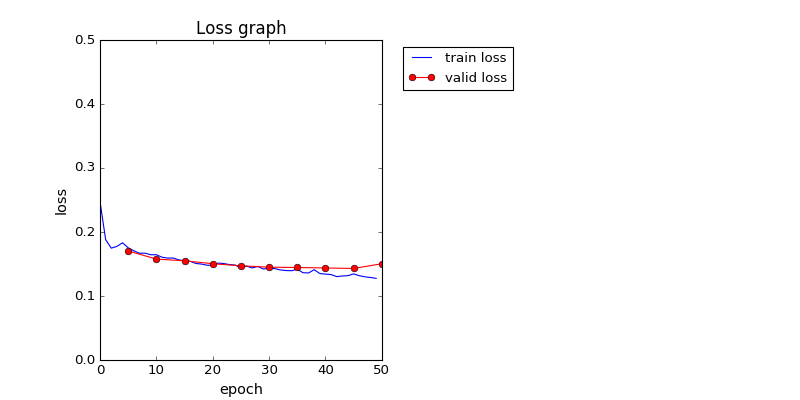

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(121)

plt.plot(train_history['loss'].tolist(), label='train loss')
plt.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')

plt.axis([0, len(train_history), 0, 0.5])
plt.legend(fontsize=12, bbox_to_anchor=(1.05,1),loc=2)
plt.title('Loss graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)

- Validation 세트에 대해서 결과 값을 확인한다.

In [15]:
start_time = time.time()
train_test = train[0,11,7]
train_test_label = train[1,11,7]

train_output = np.zeros((time_point-1,6))
for batch in iterate_2d_1((train_test-train_mean)/train_std, train_test_label, train_test.shape[0],
                                      target_delay, batch_size, time_point, time_step, 1):
    train_in, train_target = batch
    train_output = np.concatenate((train_output, model.reconstruct(data=train_in[:,np.newaxis,:,:])), axis=0)

print train_output.shape, train_test.shape
print time.time()-start_time

(154591, 6) (154678, 32)
19.2103838921


In [16]:
train_test_label = train_test_label*0.8

<IPython.core.display.Javascript object>


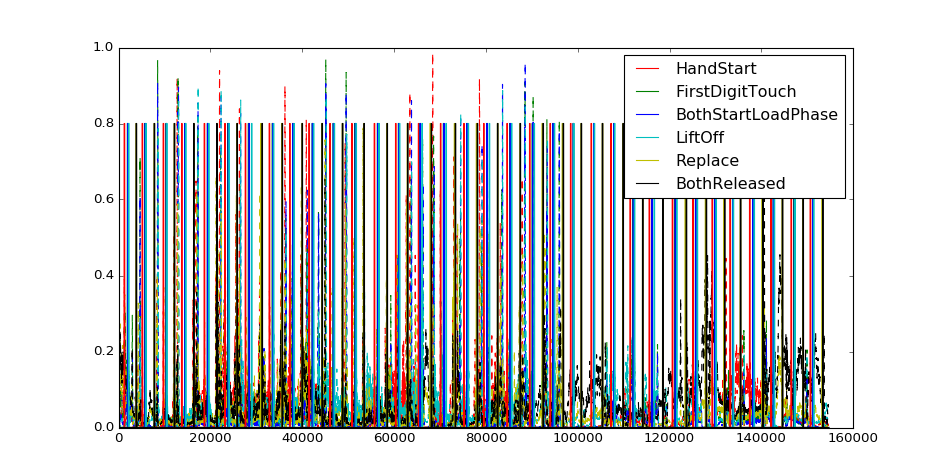

In [17]:
plt.plot(train_output[:,0], 'r--')
plt.plot(train_output[:,1], 'g--')
plt.plot(train_output[:,2], 'b--')
plt.plot(train_output[:,3], 'c--')
plt.plot(train_output[:,4], 'y--')
plt.plot(train_output[:,5], 'k--')

plt.plot(train_test_label[:,0], 'r', label = 'HandStart')
plt.plot(train_test_label[:,1], 'g', label = 'FirstDigitTouch')
plt.plot(train_test_label[:,2], 'b', label = 'BothStartLoadPhase')
plt.plot(train_test_label[:,3], 'c', label = 'LiftOff')
plt.plot(train_test_label[:,4], 'y', label = 'Replace')
plt.plot(train_test_label[:,5], 'k', label = 'BothReleased')

plt.legend()

## 7. Test
- Test 결과를 저장한다.

In [24]:
start_time = time.time()
for i in range(12):
    test_output_sub = []
    for j in range(2):
        test_output_series = np.zeros((time_point-1,6))
        for batch in iterate_2d_1((test[0,i,j]-train_mean)/train_std, test[1,i,j], test[0,i,j].shape[0],
                                  target_delay, batch_size, time_point, time_step, 1):
            test_in, test_target = batch
            test_output_series = np.concatenate((test_output_series, model.reconstruct(data=test_in[:,np.newaxis,:,:])), axis=0)

        test_output_series = np.concatenate((test_output_series, np.zeros((test[1,i,j].shape[0]-test_output_series.shape[0],6))), axis=0)
        test_output_sub.append(test_output_series)

    test_output_sub = np.asarray(test_output_sub)
    if i == 0:
        test_output = test_output_sub[np.newaxis,:]
    else:
        test_output = np.append(test_output, test_output_sub[np.newaxis,:], axis=0)
    print time.time()-start_time   

print time.time()-start_time    

100.464939117
230.05928421
327.404039145
433.245177031
546.393277168


KeyboardInterrupt: 

In [68]:
# reference : https://github.com/stupiding/kaggle_EEG
start_time = time.time()
first_line = 'id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased'

subs = np.arange(1, 13)
test_series = [9, 10]
n_events = 6
csv = []
for sub in subs:
    sub_csv = []
    for series in test_series:
        series_csv = []
        l = test_output[sub - subs[0], series - test_series[0]]
        for k in np.arange(len(l)):
            row = []
            row.append('subj' + str(sub) + '_series' + str(series) + '_' + str(k))
            for n in np.arange(n_events):
                row.append(str(l[k, n]))
            row = ','.join(row)
            series_csv.append(row)
        sub_csv.append(series_csv)
    csv.append(sub_csv)

output = []
output.append(first_line)
for series in test_series:
    for sub in subs:
        output = output + csv[sub - subs[0]][series - test_series[0]]

output = '\n'.join(output)
f = open(os.path.join('./' + model_name, 'submission.csv'), 'w')
f.write(output)
print time.time()-start_time    

30.3785231113


## 8. Submission
- 저장된 Test 결과를 Kaggle에 전송하여 확인한다.

## Appendix A.
- GPU 메모리가 부족한 경우 혹은 CPU 계산을 위한 한 단계 작은 모델
- 아래의 내용을 진행 후에 6번부터 8번까지를 진행한다.

In [9]:
class RCNN(object):
    def __init__(self, std=0.01, batch_size=128, time_point=1024, in_channels = 126, ch_multiplier=256,
                 l_rate=0.01, l_decay=0.95, l_step=1000):
        self.std = std
        self.batch_size = batch_size
        self.time_point = time_point
        self.in_channels = in_channels
        self.ch_multiplier= ch_multiplier
        
        self.global_step = tf.Variable(0, trainable=False)
        self.l_rate = tf.train.exponential_decay(l_rate, self.global_step, l_step, l_decay, staircase=True)
        
        self.y = tf.placeholder(tf.float32, [None, 6], name='y');
        self.x = tf.placeholder(tf.float32, [None, 1, self.time_point, self.in_channels], name='x')
        
        self.build_model( )
        
        #self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.output, self.y)) # softmax
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(self.output, self.y)) # sigmoid
        #self.cost = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(self.y, self.output_sigmoid)))) # RMSE
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost, global_step = self.global_step)
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()
        
        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True

        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)
        
        self.saver = tf.train.Saver(max_to_keep=10000)
        
    def build_model(self):
        self.weights, self.biases = self.init_weights()
        
        # conv
        self.conv1 = tf.nn.elu( tf.nn.bias_add( tf.nn.conv2d(input=self.x,
                                                             filter=self.weights['conv1_w'],
                                                             strides=[1,1,1,1],
                                                             padding='SAME'
                                                            ),
                                               self.biases['conv1_b']))
        
        # pooling
        self.conv1p = tf.nn.max_pool(value=self.conv1, 
                                     ksize=[1,1,4,1], 
                                     strides=[1,1,4,1], 
                                     padding='SAME')
        
        # first RCL
        self.rcl1 = tf.nn.elu(tf.nn.bias_add(tf.nn.conv2d(input=self.conv1p,
                                                          filter=self.weights['rcl1_w'],
                                                          strides=[1,1,1,1],
                                                          padding='SAME'),
                                             self.biases['rcl1_b']))
        
        self.rcl1a = tf.nn.elu(tf.add( self.rcl1, 
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl1, 
                                                                  filter=self.weights['rcl1_w'],
                                                                  strides=[1,1,1,1],
                                                                  padding='SAME'), 
                                                     self.biases['rcl1a_b'] )))
        
        self.rcl1b = tf.nn.elu(tf.add( self.rcl1,
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl1a, 
                                                                  filter=self.weights['rcl1_w'],
                                                                  strides=[1,1,1,1],
                                                                  padding='SAME'), 
                                                     self.biases['rcl1b_b'] )))
        
        # pooling
        self.rcl1p = tf.nn.max_pool(value=self.rcl1b, 
                                    ksize=[1,1,4,1], 
                                    strides=[1,1,4,1], 
                                    padding='SAME')
        
        
        # second RCL
        self.rcl2 = tf.nn.elu(tf.nn.bias_add(tf.nn.conv2d(input=self.rcl1p, 
                                                          filter=self.weights['rcl2_w'],
                                                          strides=[1,1,1,1],
                                                          padding='SAME'), 
                                             self.biases['rcl2_b']))
        
        self.rcl2a = tf.nn.elu(tf.add( self.rcl2,
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl2,
                                                                  filter=self.weights['rcl2_w'],
                                                                  strides=[1,1,1,1],
                                                                  padding='SAME'), 
                                                     self.biases['rcl2a_b'] )))
        
        self.rcl2b = tf.nn.elu(tf.add( self.rcl2,
                                      tf.nn.bias_add(tf.nn.conv2d(input=self.rcl2a, 
                                                                   filter=self.weights['rcl2_w'],
                                                                   strides=[1,1,1,1],
                                                                   padding='SAME'), 
                                                     self.biases['rcl2b_b'] )))
        
        # pooling
        self.rcl2p = tf.nn.max_pool(value=self.rcl2b,
                                    ksize=[1,1,2,1], 
                                    strides=[1,1,2,1], 
                                    padding='SAME')
            
        self.flatten = tf.reshape(self.rcl2p, shape=[-1, 1792])
    
        #self.forward1 = tf.nn.elu(tf.nn.bias_add( tf.matmul(self.flatten, self.weights['forward1_w']),
        #                           self.biases['forward1_b']))
        
        self.output = tf.nn.bias_add( tf.matmul( self.flatten, self.weights['forward1_w']),
                                     self.biases['forward1_b'])
        
        self.output_sigmoid = tf.sigmoid(self.output)

        
    def init_weights(self):
        conv1_w = tf.Variable( tf.random_normal([1, 9, self.in_channels, self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        conv1_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        
        rcl1_w = tf.Variable( tf.random_normal([1, 9, self.ch_multiplier, self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl1_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl1a_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl1b_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
 
        rcl2_w = tf.Variable( tf.random_normal([1, 9, self.ch_multiplier, self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl2_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl2a_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )
        rcl2b_b = tf.Variable( tf.random_normal([self.ch_multiplier], stddev=self.std, dtype=tf.float32 ) )

        forward1_w = tf.Variable( tf.random_normal([1792, 6],
                                                   stddev=self.std, dtype=tf.float32))
        forward1_b = tf.Variable( tf.random_normal([6],
                                                   stddev=self.std, dtype=tf.float32)) 
        #forward2_w = tf.Variable( tf.random_normal([1792, 6],
        #                                           stddev=self.std, dtype=tf.float32))
        #forward2_b = tf.Variable( tf.random_normal([6],
        #                                           stddev=self.std, dtype=tf.float32))
               
        weights = dict()
        biases = dict()
        
        weights['conv1_w'] = conv1_w
        weights['rcl1_w'] = rcl1_w
        weights['rcl2_w'] = rcl2_w
        weights['forward1_w'] = forward1_w
        #weights['forward2_w'] = forward2_w

        biases['conv1_b'] = conv1_b
        biases['rcl1_b'] = rcl1_b
        biases['rcl1a_b'] = rcl1a_b
        biases['rcl1b_b'] = rcl1b_b
        biases['rcl2_b'] = rcl2_b
        biases['rcl2a_b'] = rcl2a_b
        biases['rcl2b_b'] = rcl2b_b
        biases['forward1_b'] = forward1_b
        #biases['forward2_b'] = forward2_b
        
        return weights, biases

    def train(self, data, target):
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                             feed_dict={self.y: target,
                                        self.x: data}
                                    )
        return cost
    
    def test(self, data, target):
        cost = self.sess.run(self.cost, 
                             feed_dict={self.y: target,
                                        self.x: data}
                            )
        return cost
    
    def reconstruct(self, data):
        return self.sess.run(self.output_sigmoid, 
                             feed_dict={self.x: data}
                            )
    
    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)
        
    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")
    
    def terminate(self):
        self.sess.close()
        tf.reset_default_graph()

In [10]:
std = 0.01
batch_size = 128
time_point = 224
in_channels = 32
ch_multiplier = 256
l_rate = 1e-4
l_decay = 0.1
l_step = 1000000

time_step = 1
#time_int = 500
target_delay = np.array([0])

sample_num = 30
model_name = 'Tutorial_RCNN_small'

## Appendix B.
- 미리 저장된 모델을 불러오기

In [ ]:
if 'model' in globals():
    model.terminate()
model_name = 'Tutorial_RCNN_small'
epoch = 50

model = RCNN(std=std,
             batch_size = batch_size,
             time_point = time_point,
             in_channels = in_channels,
             ch_multiplier = ch_multiplier,
             l_rate=l_rate,
             l_decay=l_decay,
             l_step=l_step
            )
model.load( os.path.join('./' + model_name, str(epoch)+'.ckpt') )